### Statement: Fetch similar profiles and important skills using vectordb. Use the output of vectordb to create a network of companies that the people with similar profiles can refer me to.

In [1]:
import pandas as pd
from utils.sql_utils import *
import chromadb
from chromadb.utils import embedding_functions
import pandas as pd
import psycopg2
import csv
import re

In [2]:
def clean_text(text):
    # Remove everything except text, numbers, and important punctuation marks
    cleaned_text = re.sub(r'[^a-zA-Z0-9.,;:!?\s]', '', text)
    
    # Replace multiple whitespaces with a single space
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    
    return cleaned_text

### Load Vector Data

In [3]:
df = pd.read_csv("D:\\UCSD\\Fall 2023\\DSC 202\\LinkedInUnleashed\\data\\people\\us_profiles\\10000_random_us_people_profiles.csv")

In [4]:
df = df[pd.notna(df['summary'])]

In [5]:
df['summary'] = df['summary'].apply(clean_text)

In [6]:
df = df[pd.notna(df['occupation'])]

In [7]:
df = df[['full_name','occupation', 'summary']]

In [8]:
df.head()

,full_name,occupation,summary
2,Andrew Bailey,Science & Technology Counsel at National Pork ...,Experienced government affairs and public poli...
4,Alcino de Oliveira Manuel,Marketing Consultant at Alcino Media LLC,"I use the drive and commitment to help, inspir..."
5,Ali Farhat,Forensic Biomechanical Reconstructionist at VA...,I am an engineer with Masters in Biomedical en...
7,Ashleigh Ann Gardner,Actor and Playwright at Self-employed,"Writer, research professional, and performer s..."
8,Aliyah Gregory,Conservation Field Specialist at Student Conse...,"Skilled in Microsoft Word, Public Speaking, En..."


In [9]:
def getCompany(text):
    company = text.split(" at ")[1]
    return company

In [10]:
def getJobTitle(text):
    company = text.split(" at ")[0]
    return company

In [11]:
df['company'] = df['occupation'].apply(getCompany)

In [12]:
df['job_title'] = df['occupation'].apply(getJobTitle)

In [13]:
df.head()

,full_name,occupation,summary,company,job_title
2,Andrew Bailey,Science & Technology Counsel at National Pork ...,Experienced government affairs and public poli...,National Pork Producers Council,Science & Technology Counsel
4,Alcino de Oliveira Manuel,Marketing Consultant at Alcino Media LLC,"I use the drive and commitment to help, inspir...",Alcino Media LLC,Marketing Consultant
5,Ali Farhat,Forensic Biomechanical Reconstructionist at VA...,I am an engineer with Masters in Biomedical en...,VA Forensics,Forensic Biomechanical Reconstructionist
7,Ashleigh Ann Gardner,Actor and Playwright at Self-employed,"Writer, research professional, and performer s...",Self-employed,Actor and Playwright
8,Aliyah Gregory,Conservation Field Specialist at Student Conse...,"Skilled in Microsoft Word, Public Speaking, En...",Student Conservation Association,Conservation Field Specialist


In [16]:
df = df.drop_duplicates(subset='full_name', keep="first")

In [19]:
documents = []
ids = []

for i in range(0, len(df)):
    
    cleaned_text = df.iloc[i, 2]
    documents.append(cleaned_text)
    
    ## Make composite index
    id_ = str(df.iloc[i, 0])
    ids.append(id_)

sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name='paraphrase-MiniLM-L6-v2')

persistent_directory = "D:/UCSD/Fall 2023/DSC 202/LinkedInUnleashed/data/vectordb_datastore"

chroma_client = chromadb.PersistentClient(path=persistent_directory)

#chroma_client.delete_collection(name="job_postings_descriptions")

collection = chroma_client.create_collection(name="people_descriptions", embedding_function=sentence_transformer_ef)

#collection = chroma_client.get_collection(name="job_postings_descriptions")

collection.add(
    documents = documents,
    ids = ids
)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
query_string = """Data Science grad with 2 years of experience in the entire data science life cycle. 
Have multiple internships and projects in computer vision and natural language processing. Proficient with Python, R and querying
languages like SQL."""

In [154]:
results = collection.query(
    query_texts=[query_string],
    n_results=50
)

results

{'ids': [['Aadit Vyas',
   'Aakriti Gupta',
   'Abdullah Aburomeh',
   'Adam R.',
   'Azaan Barlas',
   'Aabhashree Lamichhane',
   'Aalap M',
   'Aaditya Bhat',
   'Aarohi Mehta',
   'Aakanksha Patil',
   'Aanchal Gosain',
   'Aakanksha Bharde',
   'Aabir Abubaker Kar',
   'Aamir Goriawala',
   'Aaditya Mohapatra',
   'Aaron Carney',
   'Ahmed Jaafar',
   'Aadithya Viswanath Ramasubramaniam',
   'Aafaz Ilahi',
   'Adarsh Ramchandran',
   'Kavya Reddy',
   'Aakansha Solomon',
   'Aarathi Raghuraman',
   'Aakash Rami',
   'Aadil Islam',
   'Aakriti Garg',
   'Aamash Haroon',
   'Adianelis Celada',
   'Akhil Akshintala',
   'Andrew Bates',
   'Alexandra Romero',
   'Abdullah Al Raqibul Islam',
   'Aalap Doshi',
   'Aanandan Sekaar',
   'Alyssa Peck',
   'Aaditi Vivek Saoji',
   'Ijeoma Ndidi-Amaka Akamnonu',
   'Aaroh Mathur',
   'Abhishek Tibrewal',
   'Aarohi Unadkat',
   'Aanchal Bumb',
   'Andre Acierno, M.S. Organizational Management',
   'Aaron Medina',
   'Aaditya Desai',
   'Aaro

In [155]:
document_text = " ".join(results['documents'][0])

In [156]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the stopwords dataset
nltk.download('stopwords')
nltk.download('punkt')

sws = stopwords.words('english')
other_sws = ['experience', 'university', 'working', 'engineering']

# Tokenize the string into words
words = word_tokenize(document_text)

# Remove stopwords
filtered_words = [word for word in words if word.lower() not in sws and word not in other_sws]

# Join the filtered words back into a string
output_string = ' '.join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [157]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

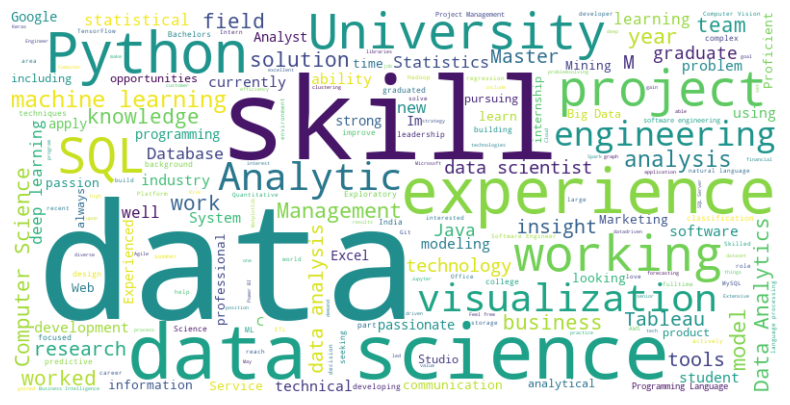

In [158]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(document_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [159]:
similar_people = results['ids'][0]

In [160]:
similar_people

['Aadit Vyas',
 'Aakriti Gupta',
 'Abdullah Aburomeh',
 'Adam R.',
 'Azaan Barlas',
 'Aabhashree Lamichhane',
 'Aalap M',
 'Aaditya Bhat',
 'Aarohi Mehta',
 'Aakanksha Patil',
 'Aanchal Gosain',
 'Aakanksha Bharde',
 'Aabir Abubaker Kar',
 'Aamir Goriawala',
 'Aaditya Mohapatra',
 'Aaron Carney',
 'Ahmed Jaafar',
 'Aadithya Viswanath Ramasubramaniam',
 'Aafaz Ilahi',
 'Adarsh Ramchandran',
 'Kavya Reddy',
 'Aakansha Solomon',
 'Aarathi Raghuraman',
 'Aakash Rami',
 'Aadil Islam',
 'Aakriti Garg',
 'Aamash Haroon',
 'Adianelis Celada',
 'Akhil Akshintala',
 'Andrew Bates',
 'Alexandra Romero',
 'Abdullah Al Raqibul Islam',
 'Aalap Doshi',
 'Aanandan Sekaar',
 'Alyssa Peck',
 'Aaditi Vivek Saoji',
 'Ijeoma Ndidi-Amaka Akamnonu',
 'Aaroh Mathur',
 'Abhishek Tibrewal',
 'Aarohi Unadkat',
 'Aanchal Bumb',
 'Andre Acierno, M.S. Organizational Management',
 'Aaron Medina',
 'Aaditya Desai',
 'Aaron Daly',
 'Aaditya Kalra',
 'Aaditi Parab',
 'Aidan McGovern',
 'Aarohi Jain',
 'Aahana Khajanchi

### Postgres

In [161]:
creds = {
    'db':"dsc_202_project",
    'user':"postgres",
    'password':"Aagaaz@786",
    'host':"localhost",
    'port':"5432"
}

In [162]:
pg_conn = psycopg2.connect(
            dbname=creds['db'],
            user=creds['user'],
            password=creds['password'],
            host=creds['host'],
            port=creds['port']
        )
pg_conn.autocommit = True
pg_cursor = pg_conn.cursor()

In [163]:
pgsql = PostgreSQL_Connector(creds)

In [164]:
def runQuery(statement, params):
        # This didn't return the newly inserted rows in table
        #db_table = pd.read_sql(statement, self.connection)
        pg_cursor.execute(statement, params)
        db_list = pg_cursor.fetchall()
        colnames = [desc[0] for desc in pg_cursor.description]
        db_table = pd.DataFrame(db_list, columns=colnames)
        return db_table

In [165]:
query = """
select distinct * from uspeople_pc
where full_name in %s
"""

In [166]:
temp = runQuery(query, (tuple(similar_people), ))

In [167]:
temp.shape

(57, 22)

### Graph

In [168]:
df = df[df['full_name'].isin(similar_people)]

In [169]:
companies = list(df['company'].unique())

In [170]:
import pandas as pd
import json
from utils import mongo_utils, pandas_utils, neo4j_utils
import matplotlib.pyplot as plt
from py2neo import Graph, Node, Relationship
import networkx as nx

In [171]:
neo_creds = {
    'host': 'localhost',
    'port': '7687',
    'user': 'neo4j',
    'password': 'Aagaaz@786'
}

uri = 'bolt://localhost:7687'

graph = Graph(uri, auth=(neo_creds['user'], neo_creds['password']))

In [172]:
graph_query = """match p=(n1)-[:SIMILAR_TO]-(d) 
where n1.name IN $array
return p
limit 25"""

In [173]:
result = graph.run(graph_query, parameters={"array": companies})

result

p
(Microsoft)<-[:SIMILAR_TO {}]-(Codazen)
(Amazon)<-[:SIMILAR_TO {}]-(1STWEST Background Due Diligence LLC)
(LexisNexis)<-[:SIMILAR_TO {}]-(21Development - Local SEO)


In [174]:
G = nx.Graph()

# Extract nodes and relationships from the result
for record in result:
    print(result)
    for rel in record["p"].relationships:
        G.add_edge(rel.start_node["name"], rel.end_node["name"])

pos = nx.spring_layout(G)  # You can change the layout algorithm as needed

 p                                                                 
-------------------------------------------------------------------
 (Amazon)<-[:SIMILAR_TO {}]-(1STWEST Background Due Diligence LLC) 
 (LexisNexis)<-[:SIMILAR_TO {}]-(21Development - Local SEO)        
 (Amazon)<-[:SIMILAR_TO {}]-(1369 Coffeehouse)                     

 p                                                          
------------------------------------------------------------
 (LexisNexis)<-[:SIMILAR_TO {}]-(21Development - Local SEO) 
 (Amazon)<-[:SIMILAR_TO {}]-(1369 Coffeehouse)              
 (Amazon)<-[:SIMILAR_TO {}]-(180 South Solar)               

 p                                             
-----------------------------------------------
 (Amazon)<-[:SIMILAR_TO {}]-(1369 Coffeehouse) 
 (Amazon)<-[:SIMILAR_TO {}]-(180 South Solar)  
 (Amazon)<-[:SIMILAR_TO {}]-(24 Seven Talent)  

 p                                                      
-------------------------------------------------------

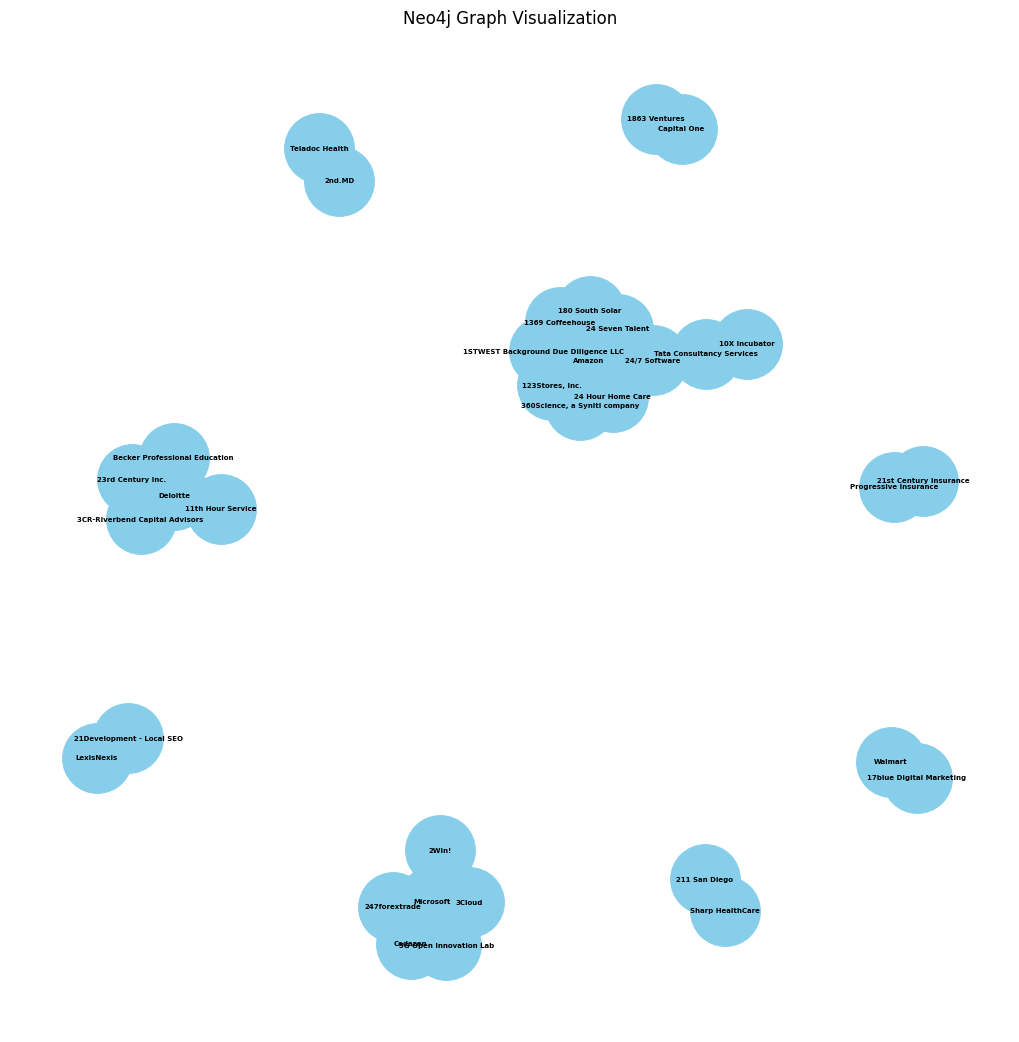

In [176]:
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='skyblue', node_size=2500, font_size=5)
plt.title("Neo4j Graph Visualization")
plt.show()